# 小レポート4

[教育用標準データセット（SSDSE）](https://www.nstac.go.jp/SSDSE/)に収録されている，都道府県庁所在市別・家計消費データ（SSDSE-2020C）に対してクラスタ分析を適用し，消費行動が類似している都道府県のクラスタを作りたい．

## (1) データのダウンロードと読み込み

都道府県庁所在市別・家計消費データ（SSDSE-2020C）をダウンロードし，都道府県の家計消費をプログラム上でロードせよ．ロードしたデータの形式は問わないが，この後のクラスタ分析が進めやすくなるように各自で検討せよ．また，各都道府県は227次元の特徴ベクトルとして表現すること．

In [4]:
import pandas as pd

In [1]:
!wget https://www.nstac.go.jp/SSDSE/data/2020/SSDSE-2020C.csv

--2021-01-27 04:20:43--  https://www.nstac.go.jp/SSDSE/data/2020/SSDSE-2020C.csv
CA証明書 '/etc/ssl/certs/ca-certificates.crt' をロードしました
www.nstac.go.jp (www.nstac.go.jp) をDNSに問いあわせています... 2403:993d:cae5:4001::2, 61.202.229.68
www.nstac.go.jp (www.nstac.go.jp)|2403:993d:cae5:4001::2|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 59823 (58K) [text/csv]
`SSDSE-2020C.csv' に保存中

SSDSE-2020C.csv     100%[===================>]  58.42K  --.-KB/s 時間 0.008s     

2021-01-27 04:20:43 (7.34 MB/s) - `SSDSE-2020C.csv' へ保存完了 [59823/59823]



(事前にShift JISだったのでutf-8に変換した．ヘッダが二行あるため扱いが著しく面倒だったので別のファイルに分けた)

In [8]:
!head SSDSE-2020C.csv -n2

In [142]:
df=pd.read_csv('SSDSE-2020C.csv')
df[:5]

,2017_2019,Prefecture,City,LA03,LB00,LB01,LB011001,LB012001,LB012002,LB013001,...,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
0,R00000,全国,全国,2.98,954715,77480,23736,9461,21430,3322,...,14885,23048,4838,12927,7082,4141,54404,7005,18785,10081
1,R01100,北海道,札幌市,2.96,910399,81474,30994,8496,18942,2973,...,19850,23858,4510,17165,7681,3688,22506,5665,26189,15619
2,R02201,青森県,青森市,2.98,878930,71992,23773,7777,17336,2777,...,13293,15006,3560,9825,7356,3107,13222,2571,14178,10745
3,R03201,岩手県,盛岡市,3.15,951176,80203,25867,8270,20622,3198,...,13807,9810,2012,6563,6897,3244,47307,4708,23046,9892
4,R04100,宮城県,仙台市,3.00,958380,70942,20207,7972,18989,2967,...,14055,15250,3440,8676,7059,3444,44302,5568,15944,7561


全国を除外しておく

In [143]:
df=df.drop(0).reset_index(drop=True)
df[:5]

,2017_2019,Prefecture,City,LA03,LB00,LB01,LB011001,LB012001,LB012002,LB013001,...,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
0,R01100,北海道,札幌市,2.96,910399,81474,30994,8496,18942,2973,...,19850,23858,4510,17165,7681,3688,22506,5665,26189,15619
1,R02201,青森県,青森市,2.98,878930,71992,23773,7777,17336,2777,...,13293,15006,3560,9825,7356,3107,13222,2571,14178,10745
2,R03201,岩手県,盛岡市,3.15,951176,80203,25867,8270,20622,3198,...,13807,9810,2012,6563,6897,3244,47307,4708,23046,9892
3,R04100,宮城県,仙台市,3.00,958380,70942,20207,7972,18989,2967,...,14055,15250,3440,8676,7059,3444,44302,5568,15944,7561
4,R05201,秋田県,秋田市,2.88,900697,68139,19508,6461,17978,3158,...,13975,13238,2352,5460,6770,2830,26648,3551,16084,12682


In [144]:
labels=pd.read_csv('SSDSE-2020C_label.csv', index_col=0).T.squeeze()

labels

Prefecture       都道府県
City                市
LA03             世帯人員
LB00           食料（合計）
LB01            01　穀類
               ...   
LB121109       ハンバーガー
LB121110      他の主食的外食
LB121201          喫茶代
LB121202          飲酒代
LB122001         学校給食
Name: 地域コード, Length: 229, dtype: object

In [145]:
data = df.drop(['2017_2019', 'Prefecture', 'City'], axis=1)
data[:5]

,LA03,LB00,LB01,LB011001,LB012001,LB012002,LB013001,LB013002,LB013003,LB013004,...,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
0,2.96,910399,81474,30994,8496,18942,2973,1974,1307,3977,...,19850,23858,4510,17165,7681,3688,22506,5665,26189,15619
1,2.98,878930,71992,23773,7777,17336,2777,2021,1016,4857,...,13293,15006,3560,9825,7356,3107,13222,2571,14178,10745
2,3.15,951176,80203,25867,8270,20622,3198,2420,1178,5651,...,13807,9810,2012,6563,6897,3244,47307,4708,23046,9892
3,3.00,958380,70942,20207,7972,18989,2967,2525,1217,4793,...,14055,15250,3440,8676,7059,3444,44302,5568,15944,7561
4,2.88,900697,68139,19508,6461,17978,3158,3969,984,4732,...,13975,13238,2352,5460,6770,2830,26648,3551,16084,12682


In [146]:
data=data.set_index(df['Prefecture'])
data[:5]

,LA03,LB00,LB01,LB011001,LB012001,LB012002,LB013001,LB013002,LB013003,LB013004,...,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
Prefecture,,,,,,,,,,,,,,,,,,,,,
北海道,2.96,910399,81474,30994,8496,18942,2973,1974,1307,3977,...,19850,23858,4510,17165,7681,3688,22506,5665,26189,15619
青森県,2.98,878930,71992,23773,7777,17336,2777,2021,1016,4857,...,13293,15006,3560,9825,7356,3107,13222,2571,14178,10745
岩手県,3.15,951176,80203,25867,8270,20622,3198,2420,1178,5651,...,13807,9810,2012,6563,6897,3244,47307,4708,23046,9892
宮城県,3.00,958380,70942,20207,7972,18989,2967,2525,1217,4793,...,14055,15250,3440,8676,7059,3444,44302,5568,15944,7561
秋田県,2.88,900697,68139,19508,6461,17978,3158,3969,984,4732,...,13975,13238,2352,5460,6770,2830,26648,3551,16084,12682


In [130]:
data.describe()

,LA03,LB00,LB01,LB011001,LB012001,LB012002,LB013001,LB013002,LB013003,LB013004,...,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
count,47.000000,4.700000e+01,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,2.974681,9.461333e+05,76170.063830,23064.255319,9415.744681,21167.787234,3298.106383,2257.404255,1133.234043,3841.978723,...,14556.148936,23657.851064,4519.680851,12628.085106,7563.212766,4286.510638,47238.638298,6279.638298,19434.510638,10841.702128
std,0.118960,6.392890e+04,5218.265331,2850.617084,1432.066210,2562.941380,781.114845,590.679626,121.459461,609.355129,...,3402.903223,6925.452953,1780.716442,5020.320325,2283.036898,813.426485,18614.128954,2369.164441,5046.315694,3317.193837
min,2.720000,7.891430e+05,65809.000000,17971.000000,6461.000000,16656.000000,1549.000000,1234.000000,855.000000,2627.000000,...,6106.000000,9810.000000,1554.000000,5460.000000,4134.000000,2127.000000,13222.000000,2571.000000,9081.000000,4330.000000
25%,2.900000,9.034520e+05,72205.000000,20731.500000,8382.500000,18995.500000,2871.500000,1894.500000,1042.000000,3404.500000,...,12267.500000,18652.000000,3382.000000,8112.000000,6578.500000,3767.500000,32413.000000,4994.000000,15998.000000,8526.500000
50%,2.960000,9.511760e+05,76555.000000,22876.000000,9176.000000,21127.000000,3266.000000,2181.000000,1141.000000,3891.000000,...,13814.000000,22948.000000,4325.000000,12054.000000,7463.000000,4394.000000,46441.000000,5760.000000,19389.000000,10483.000000
75%,3.035000,9.837700e+05,80728.000000,24776.500000,10734.500000,22874.000000,3682.500000,2430.000000,1224.000000,4079.000000,...,16657.500000,28234.500000,5645.500000,15234.000000,8165.000000,4845.500000,58445.500000,7018.500000,22404.500000,12564.000000
max,3.240000,1.123765e+06,84901.000000,30994.000000,12256.000000,26342.000000,6698.000000,4300.000000,1362.000000,5651.000000,...,23387.000000,44954.000000,9232.000000,25665.000000,14103.000000,5513.000000,108899.000000,14522.000000,37379.000000,18238.000000


In [131]:
data.dtypes

LA03        float64
LB00          int64
LB01          int64
LB011001      int64
LB012001      int64
             ...   
LB121109      int64
LB121110      int64
LB121201      int64
LB121202      int64
LB122001      int64
Length: 227, dtype: object

## (2) 最短距離法によるクラスタリング

最短距離法を用いて都道府県をクラスタリングし，デンドログラムを描画せよ．ただし，クラスタの各要素がどの都道府県であるか分かるようにせよ．

In [27]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.cluster.hierarchy import dendrogram, linkage

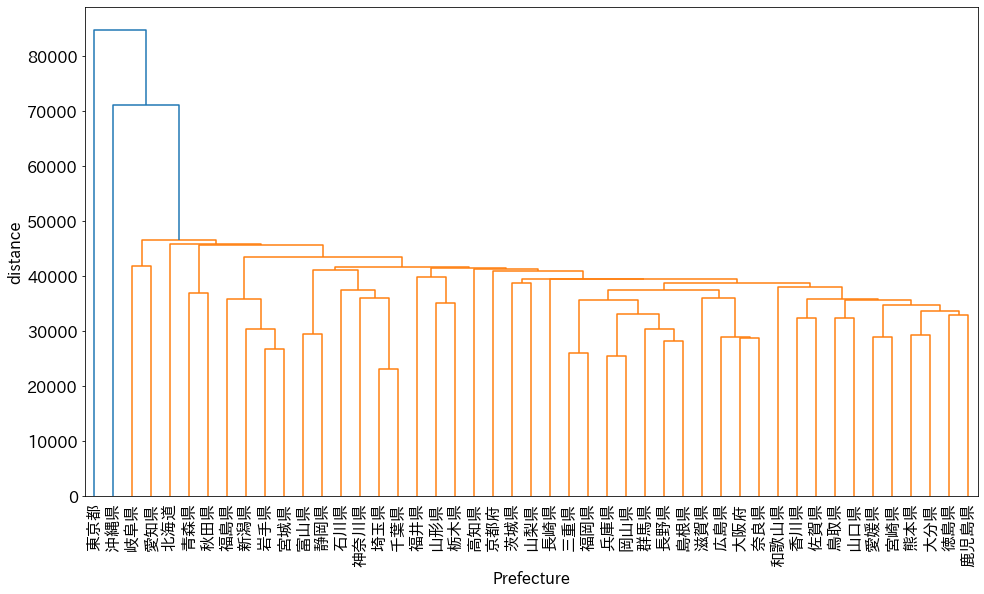

In [147]:
X=linkage(data, method='single')
plt.figure(figsize=(16, 9))
dendrogram(X, labels = data.index)
plt.tick_params(labelsize=16)
plt.ylabel('distance', fontsize=16)
plt.xlabel('Prefecture', fontsize=16)
plt.show()

## (3) 最長距離法によるクラスタリング

最長距離法を用いて都道府県をクラスタリングし，デンドログラムを描画せよ．ただし，クラスタの各要素がどの都道府県であるか分かるようにせよ．

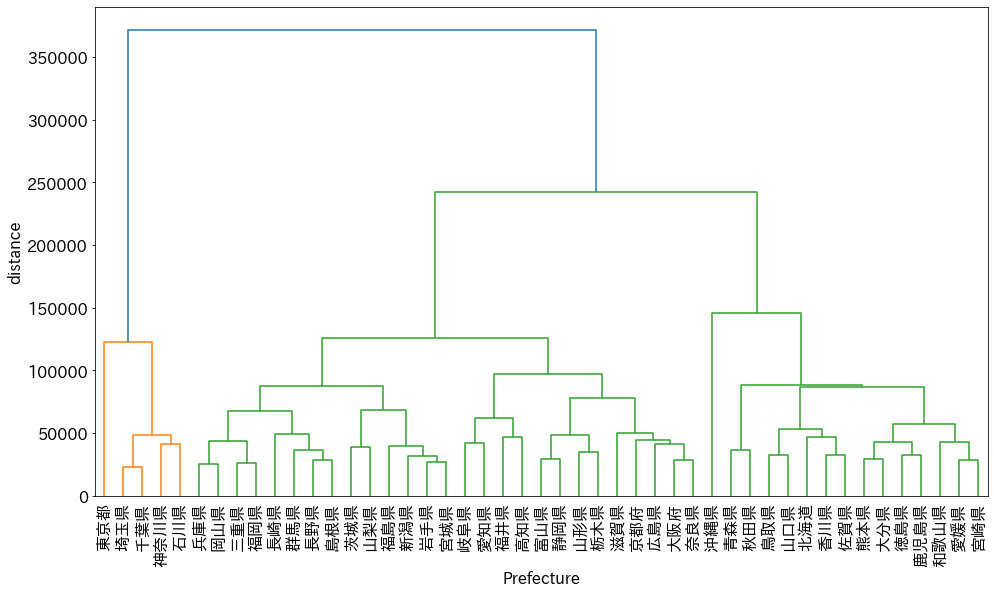

In [148]:
X=linkage(data, method='complete')
plt.figure(figsize=(16, 9))
dendrogram(X, labels = data.index)
plt.tick_params(labelsize=16)
plt.ylabel('distance', fontsize=16)
plt.xlabel('Prefecture', fontsize=16)
plt.show()

## (4) WCSSのプロット

K-meansクラスタリングを異なるクラスタ数$K$で実行し，横軸にクラスタ数，縦軸にK-meansの目的関数の値，すなわちクラスタ内平方和（WCSS: within-cluster sum-of-squares）をプロットしたグラフを描画せよ．

In [37]:
from sklearn.cluster import KMeans

In [134]:
J = []
for k in range(1, 20):
    model = KMeans(n_clusters=k)
    model.fit(data)
    J.append(model.inertia_)

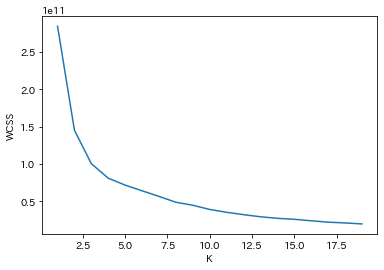

In [135]:
plt.plot(range(1,20), J)
plt.ylabel('WCSS')
plt.xlabel('K')
plt.show()

## (5) K-meansクラスタリング

(4)の結果に基づき，クラスタ数$K$を適当に選び，K-meansクラスタリングを実行せよ．$1$から$K$までの各クラスタに対して，それぞれ所属する都道府県名が分かるようにせよ．

目的関数の下がり方が鈍化したときのKを採用する方針を取れば，K=4が良いと考えられる

In [99]:
import numpy as np

In [162]:
model = KMeans(n_clusters=4)
model.fit(data)

KMeans(n_clusters=4)

In [149]:
for i in range(4):
    cluster=np.where(model.labels_==i)[0]
    print(f'cluster_{i}')
    for s in cluster:
        print(data.index[s], end=' ')
    print('')
    

cluster_0
青森県 和歌山県 山口県 徳島県 愛媛県 熊本県 大分県 宮崎県 鹿児島県 沖縄県 
cluster_1
北海道 岩手県 宮城県 秋田県 福島県 茨城県 群馬県 新潟県 山梨県 長野県 兵庫県 鳥取県 島根県 岡山県 香川県 佐賀県 長崎県 
cluster_2
埼玉県 千葉県 東京都 神奈川県 石川県 
cluster_3
山形県 栃木県 富山県 福井県 岐阜県 静岡県 愛知県 三重県 滋賀県 京都府 大阪府 奈良県 広島県 高知県 福岡県 


## (6) クラスタ分析

特徴ベクトルの作り方やクラスタリング手法を工夫し，クラスタリング結果から何らかの知見が得られるか探求せよ（この問題では227個の全ての特徴を使わなくてもよい）．そのプログラム，およびクラスタリング結果を示せ．もし興味深い結果が得られたのであれば，それを簡潔するとよい（← 報告しなくても採点に影響はない）

## xmeans

(5)ではヒューリスティックに決めたが，何らかの具体的な指標を用いたいと考えてBIC(ベイズ情報量基準)によってクラスタのデータに対する適合度を推定することを考えた

- WCSSが小さいものは誤差が小さいが，その場合，より複雑なモデルの方が良いモデルということになってしまって，クラスタリングの意味がなくなってしまう
    - 単純だけどよくクラスタリングできているなら良いモデル
- AIC（赤池情報量基準）よりもBICの方が手動で決めたときと近いらしい

xmeansというライブラリは↑の作業を自動でやってくれるらしい

In [80]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.utils import draw_clusters
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [157]:
initializer = kmeans_plusplus_initializer(data=data, amount_centers=2)
initial_centers = initializer.initialize()
xm = xmeans(data=data, initial_centers=initial_centers)
xm.process()
clusters = xm.get_clusters()

In [158]:
for i, cluster in enumerate(clusters):
    print(f'cluster_{i}')
    for s in cluster:
        print(data.index[s], end=' ')
    print('')

cluster_0
岩手県 宮城県 山形県 福島県 茨城県 栃木県 新潟県 富山県 福井県 山梨県 岐阜県 静岡県 愛知県 三重県 滋賀県 京都府 大阪府 兵庫県 奈良県 広島県 高知県 福岡県 
cluster_1
埼玉県 千葉県 神奈川県 石川県 
cluster_2
東京都 
cluster_3
北海道 青森県 秋田県 群馬県 長野県 和歌山県 鳥取県 島根県 岡山県 山口県 徳島県 香川県 愛媛県 佐賀県 長崎県 熊本県 大分県 宮崎県 鹿児島県 沖縄県 


(5)のものと比べて分け方が妥当なのかわからないが，K=4であるという点で同じだった

## TSNEによる可視化

In [178]:
from sklearn.manifold import TSNE

In [159]:
tsne = TSNE()
tsne.fit(data)

TSNE()

### xmeans

[ 5  8 15 17 20 21 22 23 24 25 26 28 33 38 39]
[ 1  4 29 30 34 35 37 42 43 44 45 46]
[10 11 12 13 16]
[ 0  2  3  6  7  9 14 18 19 27 31 32 36 40 41]


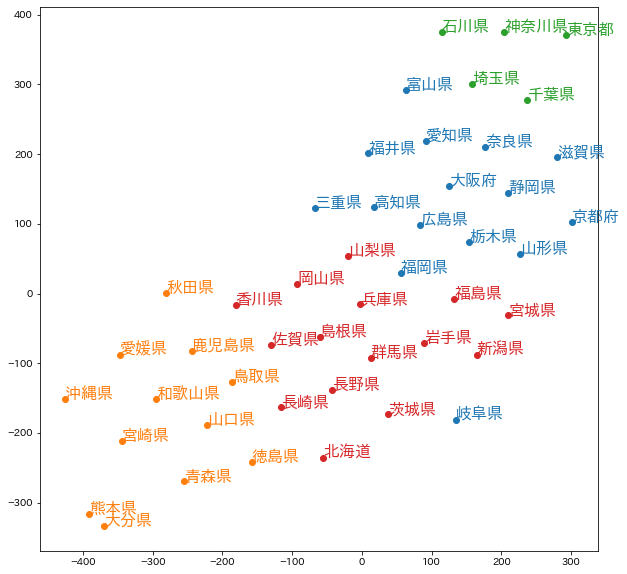

In [175]:
plt.figure(figsize=(10, 10))
for i in range(4):
    cluster=np.where(model.labels_==i)[0]
    print(cluster)
    plt.scatter(tsne.embedding_[cluster, 0], tsne.embedding_[cluster, 1], c=f'C{i}')
    for (x, y), cluster in zip(tsne.embedding_[cluster, :], cluster):
        plt.annotate( data.index[cluster], (x, y), fontsize=16, c=f'C{i}')
plt.show()

岐阜県だけ変な分け方をされている

### xmeans

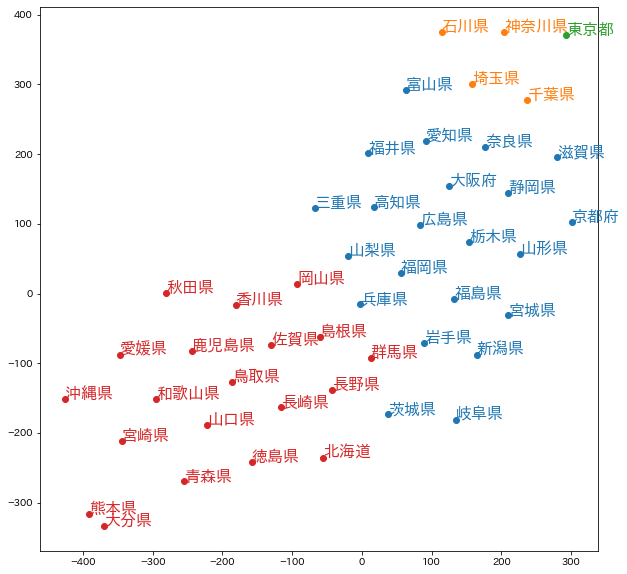

In [176]:
plt.figure(figsize=(10, 10))
for i, cluster in enumerate(clusters):
    plt.scatter(tsne.embedding_[cluster, 0], tsne.embedding_[cluster, 1], c=f'C{i}')
    for (x, y), cluster in zip(tsne.embedding_[cluster, :], cluster):
        plt.annotate(data.index[cluster], (x, y), fontsize=16, c=f'C{i}')
plt.show()

東京だけ別にクラスタリングされているのが気になるが，こっちの方が自然(tsneは距離を正確に反映できないらしい:crowding problem)

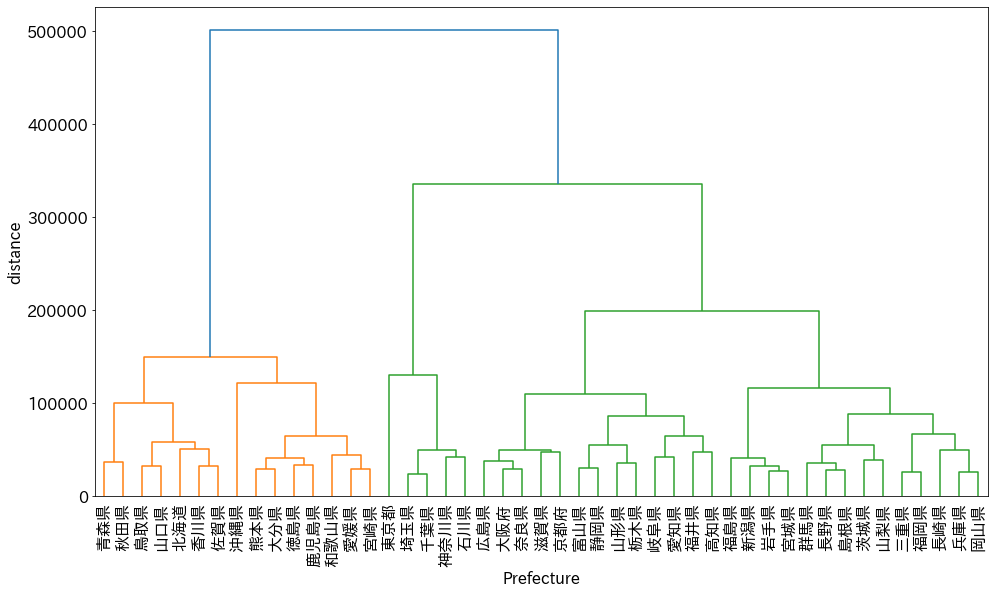

In [195]:
X=linkage(data, method='ward')
plt.figure(figsize=(16, 9))
dendrogram(X, labels = data.index)
plt.tick_params(labelsize=16)
plt.ylabel('distance', fontsize=16)
plt.xlabel('Prefecture', fontsize=16)
plt.show()

ward法による階層的クラスタリングの結果を見ると，
- 東京都
- 埼玉県
- 千葉県
- 神奈川県
- 石川県

のまとまりができており，これはxmeansの２つのクラスタ1,2と一致している．

また，ward法で黄色の領域はxmeansにおける赤とかなり対応している（例外は群馬県，長野県，島根県，岡山県，長崎県）
なお，例外のうち，群馬県，長野県，島根県は同じ系統に分類されている